Due to the limited resource of my computer, I train only with the subset data. I retrieve 100 images from `val2014/` folder.

In [1]:
# Run below command if you do not
# !poetry run python generate_subset_label_data.py --num_samples 100

Generating label file: 100%|██████████████| 100/100 [00:00<00:00, 150010.87it/s]
2024-04-04 23:16:14.066 | INFO     | __main__:<module>:40 - The output label json file path: ./data/raw/label_subset.json


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import cfg
from src.utils.manage_data_path import retrieve_data_path

_, _, _, img_list, mask_list, meta_list = retrieve_data_path(cfg.data_root_path, cfg.train_mask_data_path, cfg.val_mask_data_path, cfg.label_subset_file)

In [3]:
print(img_list[:2])
print(mask_list[:2])
print(meta_list[:2])

['./data/raw/val2014/COCO_val2014_000000000136.jpg', './data/raw/val2014/COCO_val2014_000000000139.jpg']
['./data/raw/mask/val2014/mask_COCO_val2014_000000000136.jpg', './data/raw/mask/val2014/mask_COCO_val2014_000000000139.jpg']
[{'dataset': 'COCO_val', 'isValidation': 1.0, 'img_paths': 'val2014/COCO_val2014_000000000136.jpg', 'img_width': 500.0, 'img_height': 374.0, 'objpos': [34.46, 217.675], 'image_id': 136.0, 'bbox': [0.0, 61.35, 68.92, 312.65], 'segment_area': 8458.878, 'num_keypoints': 6.0, 'joint_self': [[0.0, 0.0, 2.0], [0.0, 0.0, 2.0], [52.0, 103.0, 1.0], [0.0, 0.0, 2.0], [44.0, 102.0, 1.0], [0.0, 0.0, 2.0], [22.0, 176.0, 0.0], [0.0, 0.0, 2.0], [14.0, 265.0, 0.0], [0.0, 0.0, 2.0], [43.0, 340.0, 0.0], [0.0, 0.0, 2.0], [32.0, 340.0, 0.0], [0.0, 0.0, 2.0], [0.0, 0.0, 2.0], [0.0, 0.0, 2.0], [0.0, 0.0, 2.0]], 'scale_provided': 0.85, 'joint_others': [[38.0, 181.0, 1.0], [0.0, 0.0, 2.0], [37.0, 166.0, 1.0], [0.0, 0.0, 2.0], [10.0, 171.0, 1.0], [0.0, 0.0, 2.0], [4.0, 246.0, 1.0], [0.

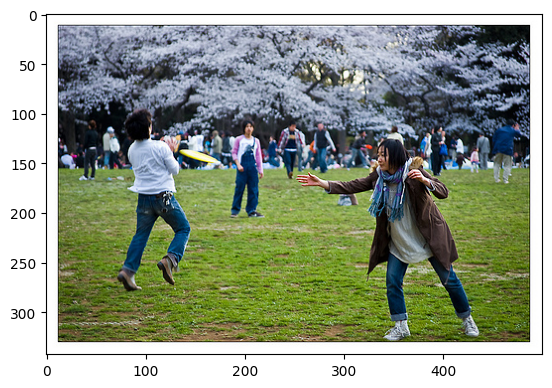

In [9]:
import random
import cv2
import matplotlib.pyplot as plt

index = random.randint(0, 99)

img = cv2.imread(img_list[index])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
_ = plt.imshow(img)

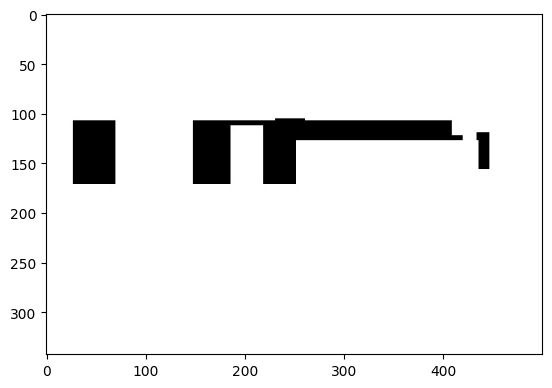

In [10]:
# Mask miss
mask_miss = cv2.imread(mask_list[index])
mask_miss = cv2.cvtColor(mask_miss, cv2.COLOR_BGR2RGB)
_ = plt.imshow(mask_miss)

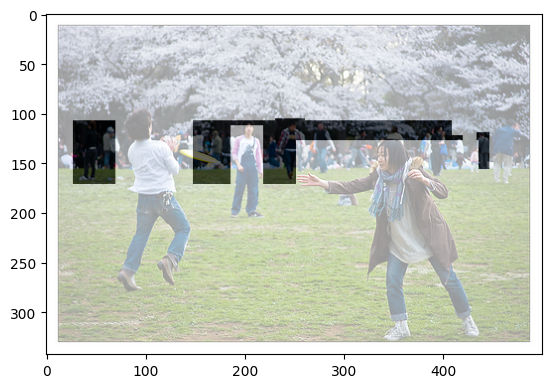

In [11]:
# Blend image and mask miss
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
_ = plt.imshow(blend_img)

### Preprocessing

In [61]:
import numpy as np
from src.utils.augment_data import (
                    Compose,
                    get_annotation,
                    add_neck,
                    aug_scale,
                    aug_rotate,
                    aug_croppad,
                    aug_flip,
                    croppad,
                    remove_illegal_joint,
                    TensorNotNormalization
)

class DataTransform:
    def __init__(self):
        self.data_transform = {
            "train": Compose(
                [
                    get_annotation,
                    add_neck,
                    aug_scale,
                    aug_rotate,
                    aug_croppad,
                    aug_flip,
                    remove_illegal_joint,
                    TensorNotNormalization(),
                ]
            ),
            "val": Compose(
                [
                    get_annotation,
                    add_neck,
                    croppad,
                    remove_illegal_joint,
                    TensorNotNormalization(),
                ]
            ),
        }

    def __call__(
        self, 
        phase: str, 
        meta_data: dict, 
        img: np.ndarray, 
        mask_miss: np.ndarray
    ):
        meta_data, img, mask_miss = self.data_transform[phase](meta_data, img, mask_miss)
        return meta_data, img, mask_miss


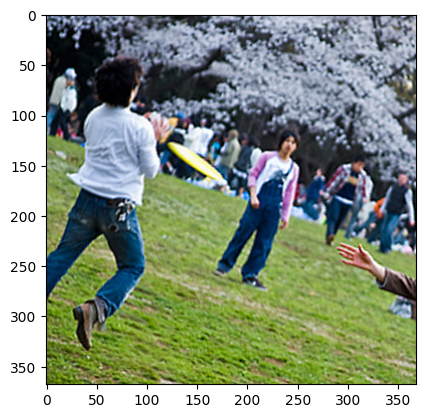

In [62]:
transform = DataTransform()

img = cv2.imread(img_list[index])
mask_miss = cv2.imread(mask_list[index])
meta_data = meta_list[index]

meta_data, img, mask_miss = transform("train", meta_data, img, mask_miss)

img = img.numpy().transpose((1, 2, 0))
_ = plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


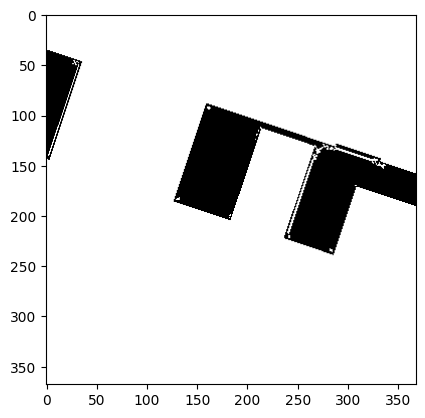

In [63]:
_mask_miss = mask_miss.numpy().transpose((1, 2, 0))
_ = plt.imshow(_mask_miss)

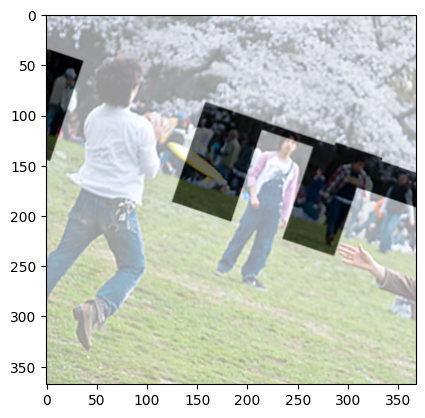

In [64]:
from PIL import Image
import numpy as np

_img = Image.fromarray(np.uint8(img*255))
_img = np.asarray(_img.convert('RGB'))
_mask_miss = Image.fromarray(np.uint8((_mask_miss)))
_mask_miss = np.asarray(_mask_miss.convert('RGB'))

blend_img = cv2.addWeighted(_img, 0.4, _mask_miss, 0.6, 0)
_ = plt.imshow(blend_img)

In [109]:
import torch
from src.utils.dataset import put_gaussian_maps, put_vec_maps

def get_ground_truth(meta, mask_miss):
    params_transform = dict()
    params_transform['stride'] = 8
    params_transform['mode'] = 5
    params_transform['crop_size_x'] = 368
    params_transform['crop_size_y'] = 368
    params_transform['np'] = 56
    params_transform['sigma'] = 7.0
    params_transform['limb_width'] = 1.0

    stride = params_transform['stride']
    mode = params_transform['mode']
    crop_size_y = params_transform['crop_size_y']
    crop_size_x = params_transform['crop_size_x']
    num_parts = params_transform['np']
    nop = meta['numOtherPeople']

    grid_y = crop_size_y / stride
    grid_x = crop_size_x / stride
    channels = (num_parts + 1) * 2

    heatmaps = np.zeros((int(grid_y), int(grid_x), 19))
    pafs = np.zeros((int(grid_y), int(grid_x), 38))

    mask_miss = cv2.resize(mask_miss, (0, 0), fx=1.0 / stride, fy=1.0 /
                           stride, interpolation=cv2.INTER_CUBIC).astype(np.float32)
    mask_miss = mask_miss / 255.
    mask_miss = np.expand_dims(mask_miss, axis=2)

    heat_mask = np.repeat(mask_miss, 19, axis=2)
    paf_mask = np.repeat(mask_miss, 38, axis=2)

    for i in range(18):
        if (meta['joint_self'][i, 2] <= 1):
            center = meta['joint_self'][i, :2]
            gaussian_map = heatmaps[:, :, i]
            heatmaps[:, :, i] = put_gaussian_maps(
                center, gaussian_map, params_transform)
        for j in range(nop):
            if (meta['joint_others'][j, i, 2] <= 1):
                center = meta['joint_others'][j, i, :2]
                gaussian_map = heatmaps[:, :, i]
                heatmaps[:, :, i] = put_gaussian_maps(
                    center, gaussian_map, params_transform)
    # pafs
    mid_1 = [2, 9, 10, 2, 12, 13, 2, 3, 4,
             3, 2, 6, 7, 6, 2, 1, 1, 15, 16]

    mid_2 = [9, 10, 11, 12, 13, 14, 3, 4, 5,
             17, 6, 7, 8, 18, 1, 15, 16, 17, 18]

    thre = 1
    for i in range(19):
        count = np.zeros((int(grid_y), int(grid_x)), dtype=np.uint32)
        if (meta['joint_self'][mid_1[i] - 1, 2] <= 1 and meta['joint_self'][mid_2[i] - 1, 2] <= 1):
            centerA = meta['joint_self'][mid_1[i] - 1, :2]
            centerB = meta['joint_self'][mid_2[i] - 1, :2]
            vec_map = pafs[:, :, 2 * i:2 * i + 2]

            pafs[:, :, 2 * i:2 * i + 2], count = put_vec_maps(centerA=centerA,
                                                            centerB=centerB,
                                                            accumulate_vec_map=vec_map,
                                                            count=count, params_transform=params_transform)
        for j in range(nop):
            if (meta['joint_others'][j, mid_1[i] - 1, 2] <= 1 and meta['joint_others'][j, mid_2[i] - 1, 2] <= 1):
                centerA = meta['joint_others'][j, mid_1[i] - 1, :2]
                centerB = meta['joint_others'][j, mid_2[i] - 1, :2]
                vec_map = pafs[:, :, 2 * i:2 * i + 2]
                pafs[:, :, 2 * i:2 * i + 2], count = put_vec_maps(centerA=centerA,
                                                                centerB=centerB,
                                                                accumulate_vec_map=vec_map,
                                                                count=count, params_transform=params_transform)
    # background
    heatmaps[:, :, -1] = np.maximum(1 - np.max(heatmaps[:, :, :18], axis=2), 0.)

    heat_mask = torch.from_numpy(heat_mask)
    heatmaps = torch.from_numpy(heatmaps)
    paf_mask = torch.from_numpy(paf_mask)
    pafs = torch.from_numpy(pafs)

    return heat_mask, heatmaps, paf_mask, pafs

### Heatmap

In [140]:
from matplotlib import cm
index = 50

img = cv2.imread(img_list[index])
mask_miss = cv2.imread(mask_list[index])
meat_data = meta_list[index]

# Preprocessing
meta_data, img, mask_miss = transform("val", meat_data, img, mask_miss)

img = img.numpy().transpose((1, 2, 0))
mask_miss = mask_miss.numpy().transpose((1, 2, 0))

# Anotation
heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss)

In [141]:
heatmaps.shape, pafs.shape

(torch.Size([46, 46, 19]), torch.Size([46, 46, 38]))

In [142]:
"""
MS COCO annotation order:
0: nose          1: left eye      2: right eye    3: left ear    4: right ear
5: left shoulder 6: right shoulder 7: left elbow  8: right elbow
9: left wrist    10: right wrist  11: left hip    12: right hip   13: left knee
14: right knee   15: left ankle   16: right ankle

Our order:
0: nose          1: neck         2: right shoulder   3: right elbow    4: right wrist
5: left shoulder 6: left elbow   7: left wrist       8: right hip
9: right knee   10: right ankle  11: left hip        12: left knee     13: left ankle
14: right eye   15: left eye     16: right ear       17: left ear      18: all
"""

'\nMS COCO annotation order:\n0: nose          1: left eye      2: right eye    3: left ear    4: right ear\n5: left shoulder 6: right shoulder 7: left elbow  8: right elbow\n9: left wrist    10: right wrist  11: left hip    12: right hip   13: left knee\n14: right knee   15: left ankle   16: right ankle\n\nOur order:\n0: nose          1: neck         2: right shoulder   3: right elbow    4: right wrist\n5: left shoulder 6: left elbow   7: left wrist       8: right hip\n9: right knee   10: right ankle  11: left hip        12: left knee     13: left ankle\n14: right eye   15: left eye     16: right ear       17: left ear      18: all\n'

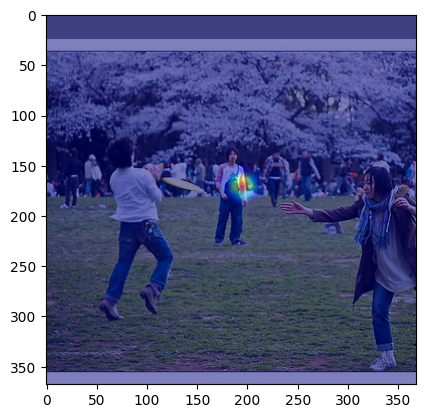

In [143]:
img_copy = img.copy()
img_copy = Image.fromarray(np.uint8(img_copy*255))
img_copy = np.asarray(img_copy.convert('RGB'))

# 6: left elbow
heat_map = heatmaps[:, :, 6]
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img_copy.shape[1], img_copy.shape[0]), interpolation=cv2.INTER_CUBIC)

blend_img = cv2.addWeighted(img_copy, 0.5, heat_map, 0.5, 0)
_ = plt.imshow(blend_img)

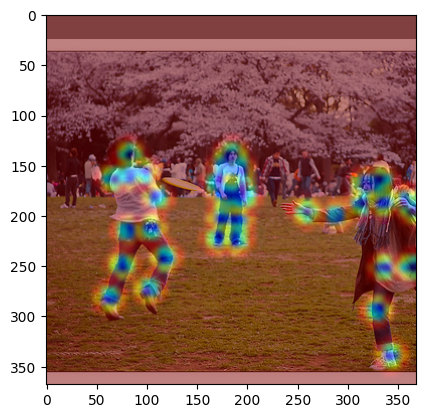

In [144]:
img_copy = img.copy()
img_copy = Image.fromarray(np.uint8(img_copy*255))
img_copy = np.asarray(img_copy.convert('RGB'))

# 18: all
heat_map = heatmaps[:, :, 18]
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img_copy.shape[1], img_copy.shape[0]), interpolation=cv2.INTER_CUBIC)

blend_img = cv2.addWeighted(img_copy, 0.5, heat_map, 0.5, 0)
_ = plt.imshow(blend_img)

### PAFs (Part Affinity Fields)

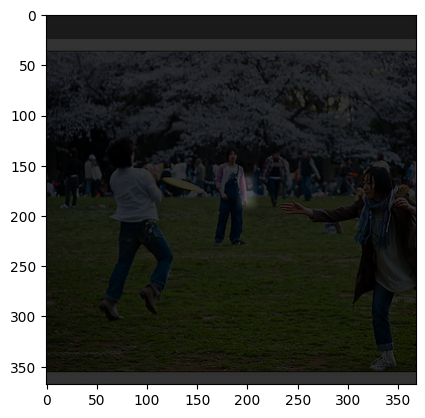

In [146]:
img_copy = img.copy()
img_copy = Image.fromarray(np.uint8(img_copy*255))
img_copy = np.asarray(img_copy.convert('RGB'))
paf = pafs[:, :, 24]

paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

blend_img = cv2.addWeighted(img_copy, 0.2, paf, 0.8, 0)
_ = plt.imshow(blend_img)

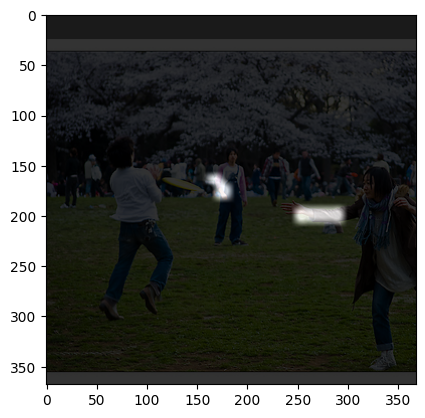

In [147]:
img_copy = img.copy()
img_copy = Image.fromarray(np.uint8(img_copy*255))
img_copy = np.asarray(img_copy.convert('RGB'))
paf = pafs[:, :, 17]

paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

blend_img = cv2.addWeighted(img_copy, 0.2, paf, 0.8, 0)
_ = plt.imshow(blend_img)

### Concatenate

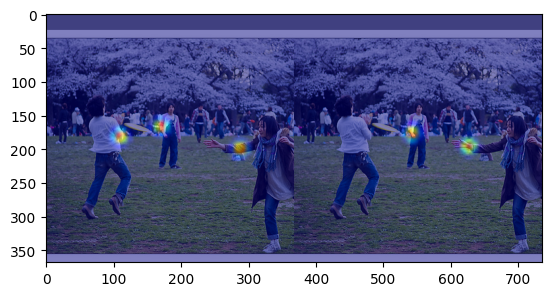

In [168]:
img_copy = img.copy()
img_copy = Image.fromarray(np.uint8(img_copy*255))
img_copy = np.asarray(img_copy.convert('RGB'))

# 3: right elbow
heat_map_right_elbow = heatmaps[:, :, 3]
heat_map_right_elbow = Image.fromarray(np.uint8(cm.jet(heat_map_right_elbow)*255))
heat_map_right_elbow = np.asarray(heat_map_right_elbow.convert('RGB'))
heat_map_right_elbow = cv2.resize(heat_map_right_elbow, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
blend_map_right_elbow = cv2.addWeighted(img_copy, 0.5, heat_map_right_elbow, 0.5, 0)

img_copy = img.copy()
img_copy = Image.fromarray(np.uint8(img_copy*255))
img_copy = np.asarray(img_copy.convert('RGB'))

# 4: right wrist
heat_map_right_wrist = heatmaps[:, :, 4]
heat_map_right_wrist = Image.fromarray(np.uint8(cm.jet(heat_map_right_wrist)*255))
heat_map_right_wrist = np.asarray(heat_map_right_wrist.convert('RGB'))
heat_map_right_wrist = cv2.resize(heat_map_right_wrist, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
blend_map_right_wrist = cv2.addWeighted(img_copy, 0.5, heat_map_right_wrist, 0.5, 0)

heat_map_blend = np.hstack([blend_map_right_elbow, blend_map_right_wrist])
_ = plt.imshow(heat_map_blend)

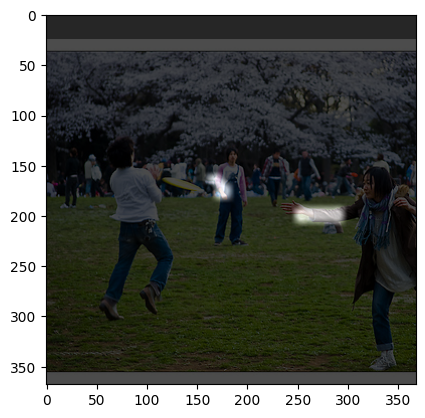

In [169]:
# PAF
img_copy = img.copy()
img_copy = Image.fromarray(np.uint8(img_copy*255))
img_copy = np.asarray(img_copy.convert('RGB'))
paf = pafs[:, :, 17]

paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
blend_img_paf = cv2.addWeighted(img_copy, 0.3, paf, 0.7, 0)
_ = plt.imshow(blend_img_paf)